In [102]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys

# Change root directory to the repo root (Jupyter: __file__ is not defined)
def find_repo_root(start=Path.cwd()):
	for p in [start] + list(start.parents):
		if (p / 'Code').exists() or (p / '.git').exists() or (p / 'local_repo').exists():
			return p
	return start

repo_root = find_repo_root()
data_root = repo_root.parent.parent / 'Data' / 'CBOS ready'

os.chdir(repo_root)
sys.path.append(str(repo_root / 'Code' / 'tools'))

# import local toolkit (try normal import first, fall back to loading from file)
try:
	import inequality_analyzers as inqA
except Exception:
	import importlib.util
	toolkit_path = repo_root / 'Code' / 'tools' / 'inequality_analyzers.py'
	if toolkit_path.exists():
		spec = importlib.util.spec_from_file_location("inequality_analyzers", str(toolkit_path))
		stk = importlib.util.module_from_spec(spec)
		spec.loader.exec_module(stk)
	else:
		raise

In [103]:
# Load final data
df = pd.read_csv(data_root / 'CBOS_data_final.csv')

# Load inflation data
inflation_data = pd.read_csv(data_root.parent / 'Auxiliary data' / 'inflation_data_cleaned.csv', index_col=0, parse_dates=True)

# Sort the inflation data by index (date)
inflation_data = inflation_data.sort_index()

# We assmue Jan 1990 to be the base month with inflation index 100
# Every other month's index is relative to previous months
inflation_data.loc[pd.Timestamp('1990-01-01')] = 100.0

# Remove older months if any
inflation_data = inflation_data[inflation_data.index >= pd.Timestamp('1990-01-01')]


/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_68595/2705073022.py:2: DtypeWarning: Columns (14,15,20,21,22,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_root / 'CBOS_data_final.csv')


In [104]:
df[df['income_hh'] > 9000]

,org_id,survey file,survey year,survey month,age,year_born,sex,sex_L,city_size,city_size_L,...,income_p_OLD_L,income_p_NEW_L,income_p_L,income_p_OLD_T,income_p_NEW_T,income_p_T,income_p_OLD_T_L,income_p_NEW_T_L,income_p_T_L,weight
37580,1053.0,CBOS_29_11_1992.sav,1992,11,0,1962.0,2.0,Kobieta,1.0,wsią,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.000000
75532,989.0,CBOS_63_08_1995.sav,1995,8,0,1909.0,1.0,Mężczyzna,5.0,Od 100 do 200 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,0.375161
80931,526.0,CBOS_68_01_1996.sav,1996,1,0,1953.0,2.0,Kobieta,3.0,Miastem: od 20 do 50 tys. mieszkańców,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.637138
108999,999.0,CBOS_91_12_1997.sav,1997,12,0,1925.0,1.0,Mężczyzna,1.0,Wsią,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,0.521206
111472,86.0,CBOS_94_03_1998.sav,1998,3,0,1961.0,2.0,Kobieta,1.0,wsią,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.042912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355433,783.0,CBOS_328_09_2017.sav,2017,9,0,1977.0,1.0,Mężczyzna,6.0,miasto 500 000 i więcej,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.448216
355560,910.0,CBOS_328_09_2017.sav,2017,9,0,1984.0,1.0,Mężczyzna,1.0,wieś,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.823887
355767,132.0,CBOS_329_10_2017.sav,2017,10,0,1962.0,1.0,Mężczyzna,6.0,miasto 500 000 i więcej,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,0.892803
357364,781.0,CBOS_330_11_2017.sav,2017,11,0,1955.0,1.0,Mężczyzna,6.0,miasto 500 000 i więcej,...,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,1.003973


In [105]:
### Deflate the income_hh variable using the inflation data

# First, create a survey_date column in df
df['survey_date'] = pd.to_datetime(df['survey year'].astype(str) + '-' + df['survey month'].astype(str) + '-01', format='%Y-%m-%d')

df['income_hh_ALL'] = np.nan  # Initialize the ALL income_hh column
df['income_hh_deflated'] = np.nan  # Initialize the deflated income_hh column

# Now, deflate income_hh to first month (01) of the first survey year (1990)
# The price index for that month is 100, the next price index is for 02/1990 compared to 01/1990, etc.
# Generally: price index of month M in year Y is relative to month M-1 in year Y (or M=12 in year Y-1 if M=1)

old_survey_date = None

for idx, row in df.iterrows():
    survey_date = row['survey_date']
    if survey_date != old_survey_date:
        price_indicies = inflation_data[inflation_data.index <= survey_date]
        compound_price_index = 100.0 * np.prod(price_indicies.values/100.0)
    '''
    if row['income_hh_OLD'] is not np.nan and row['income_hh_OLD'] > 0:
        df.at[idx, 'income_hh_ALL'] = row['income_hh_OLD']/10
    elif row['income_hh_NEW'] is not np.nan and row['income_hh_NEW'] > 0:
        df.at[idx, 'income_hh_ALL'] = row['income_hh_NEW']
    else:
        df.at[idx, 'income_hh_ALL'] = np.nan
    
    if not np.isnan(df.at[idx, 'income_hh_ALL']):
        df.at[idx, 'income_hh_deflated'] = df.at[idx, 'income_hh_ALL'] * (100.0 / compound_price_index)
    '''
    if not np.isnan(df.at[idx, 'income_hh']):
        df.at[idx, 'income_hh_deflated'] = df.at[idx, 'income_hh'] * (100.0 / compound_price_index)
        
    old_survey_date = survey_date
    

In [106]:
inflation_data

,inflation_index
1990-01-01,100.0
1990-02-01,123.8
1990-03-01,104.3
1990-04-01,107.5
1990-05-01,104.6
...,...
2025-08-01,100.0
2025-09-01,100.0
2025-10-01,100.1
2025-11-01,100.1


In [107]:
df[['survey_date', 'income_hh_OLD', 'income_hh_NEW', 'income_hh_ALL', 'income_hh_deflated']]

,survey_date,income_hh_OLD,income_hh_NEW,income_hh_ALL,income_hh_deflated
0,1990-01-01,380.0,0.0,NaN,38.000000
1,1990-01-01,400.0,0.0,NaN,40.000000
2,1990-01-01,170.0,0.0,NaN,17.000000
3,1990-01-01,375.0,0.0,NaN,37.500000
4,1990-01-01,430.0,0.0,NaN,43.000000
...,...,...,...,...,...
358520,2017-12-01,0.0,NaN,NaN,NaN
358521,2017-12-01,0.0,1500.0,NaN,61.934773
358522,2017-12-01,0.0,900.0,NaN,37.160864
358523,2017-12-01,0.0,1500.0,NaN,61.934773


In [108]:
IA_defl = inqA.InequalityAnalyzer(df, income_col='income_hh_deflated')
IA = inqA.InequalityAnalyzer(df, income_col='income_hh')

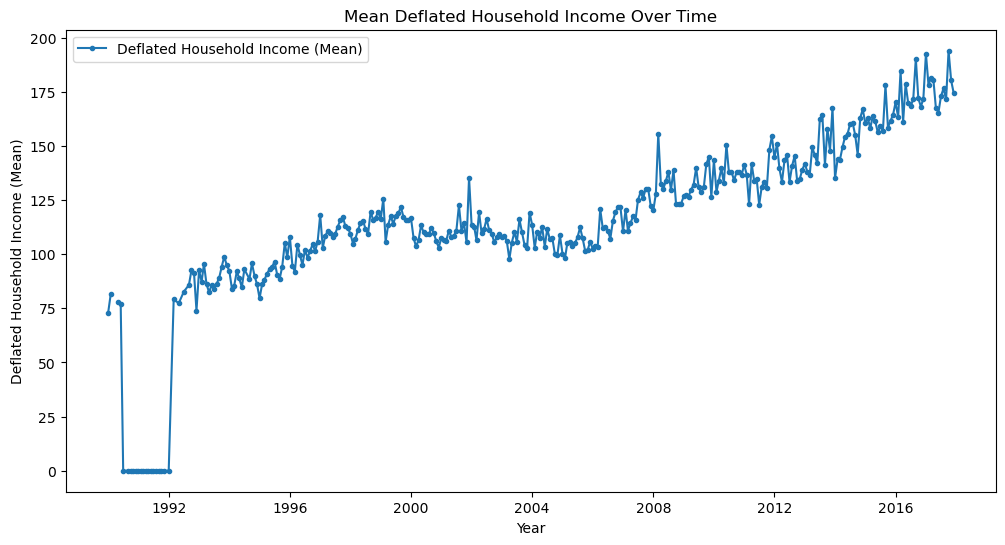

In [109]:
# plot means over time
import matplotlib.pyplot as plt

ts_defl = IA_defl.time_series.weighted_mean_total.values
ts = IA.time_series.weighted_mean_total.values

plt.figure(figsize=(12, 6))
#plt.plot(IA.time_series.index, ts, label='Nominal Household Income (Mean)', marker='.')
plt.plot(IA_defl.time_series.index, ts_defl, label='Deflated Household Income (Mean)', marker='.')
plt.xlabel('Year')
plt.ylabel('Deflated Household Income (Mean)')
plt.title('Mean Deflated Household Income Over Time')
plt.legend()
plt.show()  

In [110]:
# Reload the module to pick up changes
import importlib
importlib.reload(inqA)

<module 'inequality_analyzers' from '/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/Long-run dynamics of wealth inequalities/Paper/local_repo/LRDWI-Paper/Code/tools/inequality_analyzers.py'>